# Generating Model Flux Arrays

The data to recreate the best galaxy, star, and QSO models for a given fiber's flux information can be found by using information in the spZall fits file for a plate and several eigen spectra fits files that come with the IDLSPEC2D package from SDSS. This notebook uses the fitsio, bossdata, and speclite packages to generate models.

In [1]:
import bossdata.path
import bossdata.remote
import bossdata.spec
import fitsio
import speclite
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()
temp_folder = mirror.local_path('BOSS_templates')

In [3]:
def make_model(plate, mjd, fiber, wlen, num = 1):
    """
    Return numpy structured array of flux for model
    
    Args:
        plate(int): plate number (must be valid plate number)
        mjd(ind): Modified Julian Date of observation for given plate
        fiber(int): fiber number of object to model
        wlen(np.array): wavelength array for given fiber
        num(int): integer between 1 and 134 (inclusive) denoting which model to generate.
            1 denotes best fit, 2 denotes second best, etc.
    
    Returns:
        model(np.array): numpy structured array of the same length as wlen with flux of model
    """
    remote = '/sas/dr12/boss/spectro/redux/v5_7_0/{0}/v5_7_0/spZall-{0}-{1}.fits'
    local = mirror.get(remote.format(plate, mjd))
    Z_all = fitsio.FITS(local)
    Z_info = Z_all[1]['Z','TFILE','TCOLUMN','NPOLY','THETA'][(fiber-1)*134 + num - 1]
    Z_all.close()
    
    template_file = Z_info['TFILE'][0].strip()
    num_col = np.argmin(Z_info['TCOLUMN'])
    template_fits = fitsio.FITS('{}/{}'.format(mirror.local_path('BOSS_templates'),template_file))
    header = template_fits[0].read_header()
    eigen_spectra = template_fits[0][:,:]
    template_fits.close()
    
    flux = np.zeros(len(eigen_spectra[0]), dtype =[('flux','float32')])
    for i in range(num_col):
        flux['flux'][:] = flux['flux'] + Z_info['THETA'][0][i] * eigen_spectra[i]
    index = np.arange(len(flux['flux']), dtype= 'float32') * header['COEFF1']
    poly = np.zeros(len(flux['flux']), dtype = 'float32')
    for j in range(Z_info[0]['NPOLY']):
        poly = poly + index**j * Z_info[0]['THETA'][num_col + j]
    index = index + header['COEFF0']
    flux['flux'][:] = flux['flux'] + poly
    
    rs_wlen = speclite.redshift(0, Z_info[0]['Z'],rules=[dict(name='wlen', exponent=+1, array_in = 10**index)])
    model = speclite.resample(flux , rs_wlen['wlen'].astype('float32'), wlen, ('flux'))
    
    return model

In [4]:
p = 4053
m = 55591
f = 359

To get the wavelength array, use bossdata. For the purposes of comparison, taking the best fit model array from the spec file will allow for plotting both versions of the best fit model.

In [5]:
remote_path = finder.get_spec_path(plate=p, mjd=m, fiber=f, lite=True)
local_path = mirror.get(remote_path)
info = bossdata.spec.SpecFile(local_path)
data = info.get_valid_data()
wlen, flux, dflux = data['wavelength'][:], data['flux'][:], data['dflux'][:]
model = info.hdulist[1]['model'][:]

In [6]:
test_model = make_model(p, m, f, wlen)

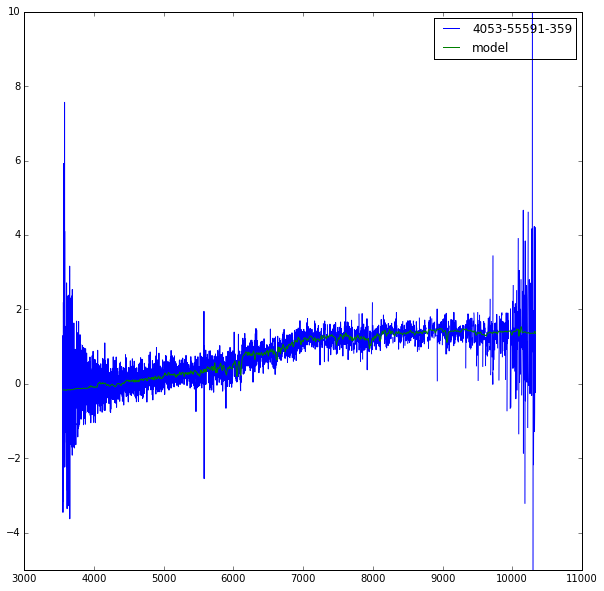

In [7]:
plt.figure(figsize = (10,10))
plt.plot(wlen, flux, label = '{}-{}-{}'.format(p, m, f))
plt.plot(wlen, test_model, label = 'model')
plt.legend()
plt.ylim((-5,10))
plt.show()

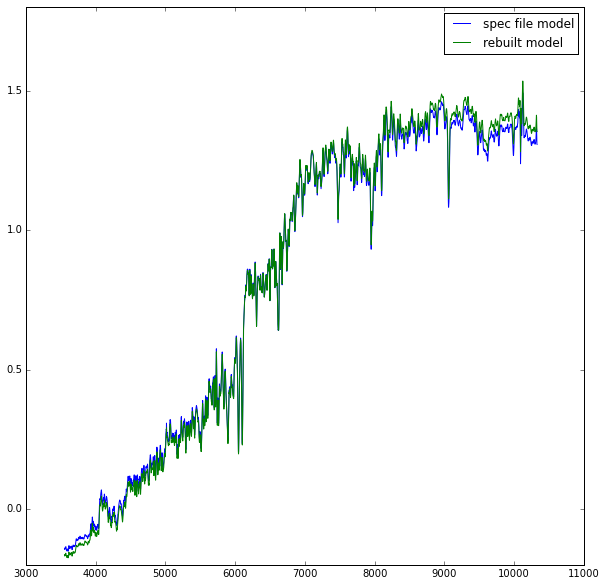

In [8]:
plt.figure(figsize = (10,10))
plt.plot(wlen, model, label = 'spec file model')
plt.plot(wlen, test_model, label = 'rebuilt model')
plt.ylim((-0.2,1.8))
plt.legend()
plt.show()